# Cole-Cole

There are various different definitions of a cole-cole model, see for instance Tarasov and Titov (2013). We try two different ones here, but you can supply your preferred version.

One model is given by Cole and Cole (1941),

$$
\sigma^* = \sigma_\infty + \frac{\sigma_0 - \sigma_\infty}{1 + (i\omega\tau)^c}\ .
$$

Another one by Pelton et al. (1978),

$$
\rho^* = \rho_\infty + \frac{\rho_0 - \rho_\infty}{1 + (i\omega\tau)^c}\ .
$$


The second one just is like the first one, but replaces $\sigma$ by $\rho$. However, mathematically they are not the same. Substituting $rho = 1/\sigma$ in the second equation and resolving it for $\sigma$ will not yield the first equation.

In both cases we add the the part coming form displacement currents.

## WARNING

This is work in progress and might change anytime. **It is not working with the stable release of empymod**. You have to use the branch [cole-cole](https://github.com/empymod/empymod/tree/cole-cole).

### References

**Cole, K.S., and R.H. Cole, 1941**, Dispersion and adsorption in dielectrics. I. Alternating current characteristics; *Journal of Chemical Physics*, Volume 9, Pages 341-351, doi: [10.1063/1.1750906](https://doi.org/10.1063/1.1750906).

**Pelton, W.H., S.H. Ward, P.G. Hallof, W.R. Sill, and P.H. Nelson, 1978**, Mineral discrimination and removal of inductive coupling with multifrequency IP, *Geophysics*, Volume 43, Pages 588-609, doi: [10.1190/1.1440839](https://doi.org/10.1190/1.1440839).

**Tarasov, A., and K. Titov, 2013**, On the use of the Cole–Cole equations in spectral induced polarization; *Geophysical Journal International*, Volume 195, Issue 1, Pages 352-356, doi: [10.1093/gji/ggt251](https://doi.org/10.1093/gji/ggt251).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from empymod import bipole, versions
from empymod.utils import _check_var

## Define the Cole-Cole model

We define our models here which we will feed to `empymod.dipole` or `empymod.bipole`. You have to leave the input signature `function_name(cond, freq, aniso, etaH, etaV)` and the output signature `return etaH, etaV` unchanged, but everything else you can adjust to your needs.

By default, `etaH`/`etaV` are calculated like this:
    
    etaH = 1/res + 2j*np.pi*freq*epermH*epsilon_0
    etaV = 1/(res*aniso**2) + 2j*np.pi*freq*epermV*epsilon_0

With this function we recalculate it. We replace the real part, the conductivity, by a complex, frequency-dependent conductivity. Then we add back the imaginary part coming from eperm (basically zero for low frequencies).

In [2]:
def cole_cole(cond, freq, aniso, etaH, etaV):
    """Cole and Cole (1941)."""   
    # Get required variables from cond, check them.
    cond_0 = _check_var(cond['cond_0'], float, 1, 'cond_0', etaH[0, :].shape)
    cond_8 = _check_var(cond['cond_8'], float, 1, 'cond_8', cond_0.shape)
    tau = _check_var(cond['tau'], float, 1, 'cond_tau', cond_0.shape)
    c = _check_var(cond['c'], float, 1, 'cond_c', cond_0.shape)

    # Calculate complex conductivity from cole-cole
    iomega = 2j*np.pi*freq
    condH = cond_8 + (cond_0-cond_8)/(1 + np.outer(iomega, tau)**c)
    condV = condH/aniso**2

    # Add electric permittivity
    etaH = condH + 1j*etaH.imag
    etaV = condV + 1j*etaV.imag

    return etaH, etaV

def pelton_et_al(cond, freq, aniso, etaH, etaV):
    """ Pelton et al. (1978)."""
    # Get required variables from cond, check them.
    rho_0 = _check_var(cond['rho_0'], float, 1, 'cond_0', etaH[0, :].shape)
    rho_8 = _check_var(cond['rho_8'], float, 1, 'cond_8', rho_0.shape)
    tau = _check_var(cond['tau'], float, 1, 'cond_tau', rho_0.shape)
    c = _check_var(cond['c'], float, 1, 'cond_c', rho_0.shape)

    # Calculate complex conductivity from cole-cole
    iomega = 2j*np.pi*freq
    rhoH = rho_8 + (rho_0-rho_8)/(1 + np.outer(iomega, tau)**c)
    rhoV = rhoH*aniso**2

    # Add electric permittivity
    etaH = 1/rhoH + 1j*etaH.imag
    etaV = 1/rhoV + 1j*etaV.imag

    return etaH, etaV

## Example


:: empymod END; runtime = 0:00:00.041696 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.066854 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.062177 :: 1 kernel call(s)



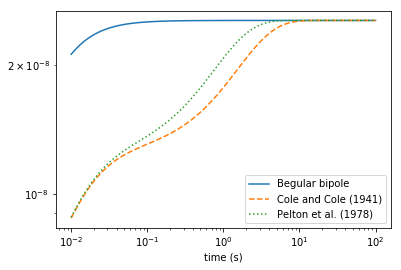

In [3]:
# Times
times = np.logspace(-2, 2, 101)

# Model parameter
model = {
    'src': [0, 0, 1e-5, 0, 0],
    'rec': [500, 0, 1e-5, 0, 0],
    'depth': 0,
    'epermH': [0, 1],  # To improve early times in land CSEM
    'epermV': [0, 1],  # (diffusive approximation for airwave)
    'freqtime': times,
    'signal': 1,
}

# Resistivity (for regular bipole-result)
res = np.array([2e14, 10])
res2 = np.array([2e14, 5])

# Define `cond`, it MUST contain two entries:
# - 'res': Used to calculate regular etaH, etaV
# - 'func': The Cole-Cole function
# Aditionally all parameters you use in `func`.

# For Cole and Cole
cond = {
    'res': res,
    'cond_0': 1/res, # cond_0  (we take the inverse of res here)
    'cond_8': 1/res2,
    'tau': [1, 1],
    'c': [1, 1],
    'func': cole_cole
}

# For Pelton et al
rho = {
    'res': res,
    'rho_0': res, # rho_0  (we take the inverse of res here)
    'rho_8': res2,
    'tau': [1, 1],
    'c': [1, 1],
    'func': pelton_et_al
}

out_dip = bipole(res=[2e14, 10], **model)
out_cole = bipole(res=cond, **model)
out_pelton = bipole(res=rho, **model)

plt.figure()
plt.plot(times, out_dip, '-', label='Begular bipole')
plt.plot(times, out_cole, '--', label='Cole and Cole (1941)')
plt.plot(times, out_pelton, ':', label='Pelton et al. (1978)')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('time (s)')
plt.show()

In [4]:
versions('HTML')